## Simulate the effect of precipitation uncertainty.

In [33]:
# Library imports.
from datetime import datetime, timedelta
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Local imports.
from urbansurge import swmm_model

### Measured precipitation.

In [30]:
# Load in precipitation used to force the physical model.
true_prcp_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\impulse_ramp_n20_60min.dat"
true_prcp_df = pd.read_csv(true_prcp_fp, sep='\s+', header=None)
true_prcp = true_prcp_df.iloc[:,2].to_numpy()
print(true_prcp_df)

              0         1    2
0    01/01/2020  00:00:00  0.0
1    01/01/2020  00:05:00  0.0
2    01/01/2020  00:10:00  0.0
3    01/01/2020  00:15:00  0.0
4    01/01/2020  00:20:00  0.0
..          ...       ...  ...
284  01/01/2020  23:40:00  0.0
285  01/01/2020  23:45:00  0.0
286  01/01/2020  23:50:00  0.0
287  01/01/2020  23:55:00  0.0
288  01/02/2020  00:00:00  0.0

[289 rows x 3 columns]


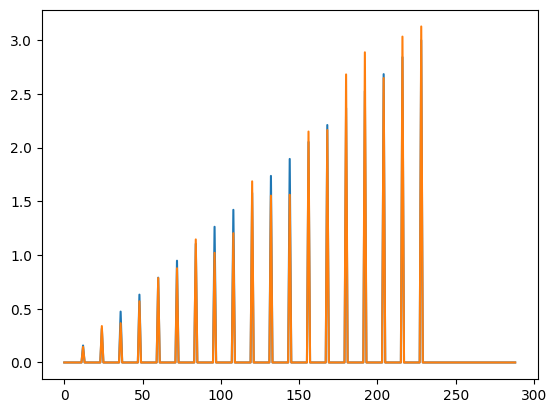

In [14]:
# Add measurement uncertainty to true prcp.

# Normally distributed noise.
sig = 0.1
meas_noise = np.random.normal(0, sig, len(true_prcp)) * true_prcp

# Add to true prcp.
meas_prcp = true_prcp + meas_noise
meas_prcp[meas_prcp < 0] = 0.0

fig, ax = plt.subplots()
ax.plot(true_prcp)
ax.plot(meas_prcp)

### Forcing ensemble from measured precipitation.

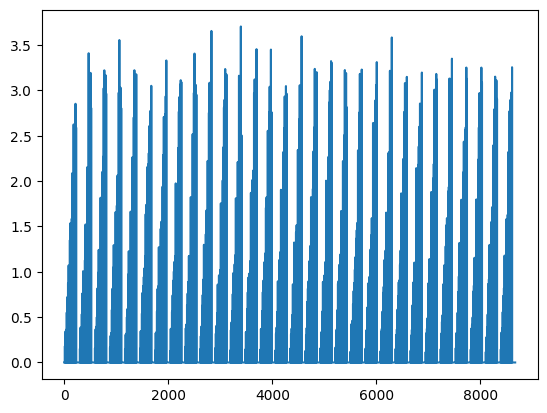

In [44]:
# Create forcing ensemble from measured precip.
Nens = 30
ens_sig = 0.1

ensemble_prcp = np.zeros((len(meas_prcp), Nens))
for i in range(Nens):
    ens_noise = np.random.normal(0, sig, len(meas_prcp)) * meas_prcp
    ens_prcp = meas_prcp + ens_noise
    ens_prcp[ens_prcp < 0] = 0.0
    ensemble_prcp[:,i] = ens_prcp
    
# Stack ensemble precip into a single long array.
ensemble_prcp_strip = ensemble_prcp.flatten(order='F')

fig, ax = plt.subplots()
ax.plot(ensemble_prcp_strip)

# Create a data frame for the ensemble precip.
ensemble_df = pd.concat([true_prcp_df]*Nens)
ensemble_df.iloc[:,2] = ensemble_prcp_strip

# Create the date array.
start_datetime = datetime.strptime(true_prcp_df.iloc[0,0], '%m/%d/%Y')
t = [start_datetime + timedelta(minutes=5 * i) for i in range(ensemble_df.shape[0])]
t_date = [datetime.strftime(i, '%m/%d/%Y') for i in t]
t_time = [datetime.strftime(i, '%H:%M:%S') for i in t]
ensemble_df.iloc[:,0] = t_date
ensemble_df.iloc[:,1] = t_time

# Save the ensemble dataframe as a .dat file.
ensemble_df_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\ensemble_prcp.dat"
ensemble_df.to_csv(ensemble_df_fp, index=False, header=False, sep='\t')

In [40]:
ensemble_df.head()

,0,1,2
0,01/01/2020,00:00:00,0.0
1,01/01/2020,00:05:00,0.0
2,01/01/2020,00:10:00,0.0
3,01/01/2020,00:15:00,0.0
4,01/01/2020,00:20:00,0.0


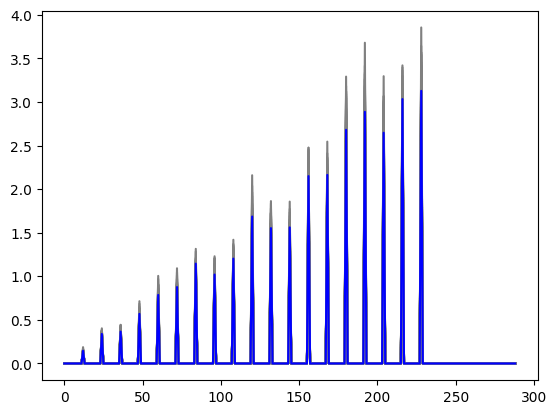

In [23]:
fig, ax = plt.subplots()
ax.plot(ensemble_prcp, 'gray')
ax.plot(meas_prcp, 'blue')